# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [20]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

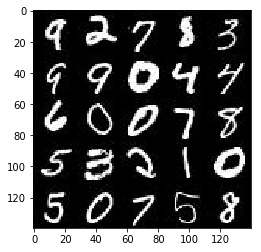

In [24]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

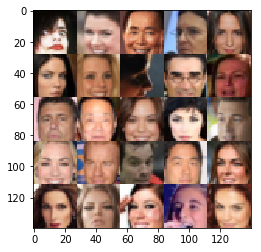

In [25]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0-rc2
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [27]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real_input, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    i

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [28]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    depth1 = 32
    depth2 = 2*depth1
    depth3 = 2*depth2
    
    def leaky_relu(inp):
            return tf.maximum(inp, inp*alpha)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, depth1, 5, strides=2, padding='same')
        l1 = leaky_relu(l1)
        
        l2 = tf.layers.conv2d(l1, depth2, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = leaky_relu(l2)
            
        l3 = tf.layers.conv2d(l2, depth3, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = leaky_relu(l3)
        
        flatten = tf.reshape(l3, [-1, 4*4*depth3])
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    depth1 = 512
    depth2 = depth1 // 2
    depth3 = depth2 // 2
    
    def leaky_relu(inp):
            return tf.maximum(inp, inp*alpha)
        
    with tf.variable_scope('generator', reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*depth1)
        l1 = tf.reshape(l1, [-1, 7, 7, depth1])
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = leaky_relu(l1)
        # 7 x 7
        
        l2 = tf.layers.conv2d_transpose(l1, depth2, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = leaky_relu(l2)
        # 14 x 14
        
        l3 = tf.layers.conv2d_transpose(l2, depth3, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = leaky_relu(l3)
        # 28 x 28
        
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)
        # 28 x 28 x out_channel_dim
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, alpha=alpha)
    d_output_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_output_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_output_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [31]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                step += 1
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                feed = {real_input: batch_images, z: batch_z, lr: learning_rate}
                sess.run(d_train_opt, feed_dict=feed)
                sess.run(g_train_opt, feed_dict=feed)
                
                # print information every _ steps
                if step % print_every == 0:
                    train_loss_d = d_loss.eval(feed)
                    train_loss_g = g_loss.eval(feed)
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # show generated image samples every _ steps
                if step % show_every == 0:
#                     gen_samples = sess.run(generator(z, data_shape[3], is_train=False), feed_dict=feed)
#                     samples.append(gen_samples)
#                     pyplot.imshow(helper.images_square_grid(gen_samples, data_image_mode)) # cmap='gray')
                    show_generator_output(sess, batch_size, z, data_shape[3], data_image_mode)
                    
#         saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [52]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 3.1943... Generator Loss: 0.0821
Epoch 1/2... Discriminator Loss: 2.8523... Generator Loss: 0.1748


KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.7967... Generator Loss: 0.0418
Epoch 1/1... Discriminator Loss: 3.5681... Generator Loss: 0.0593
Epoch 1/1... Discriminator Loss: 3.1797... Generator Loss: 0.1214
Epoch 1/1... Discriminator Loss: 2.3549... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 2.4939... Generator Loss: 0.3226
Epoch 1/1... Discriminator Loss: 1.7675... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.8098... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 1.9876... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 2.0259... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.9152... Generator Loss: 0.4901


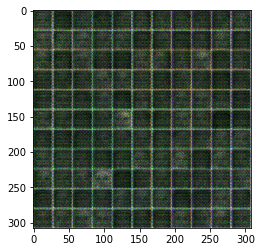

Epoch 1/1... Discriminator Loss: 1.7599... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.7346... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 1.9022
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.6804


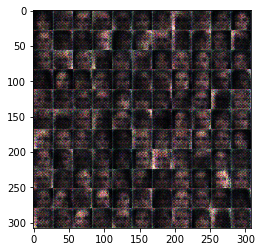

Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 2.0423
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 2.6787
Epoch 1/1... Discriminator Loss: 0.2497... Generator Loss: 2.4285
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 2.2022
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 0.1508... Generator Loss: 2.6350
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 3.0464
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 3.4561


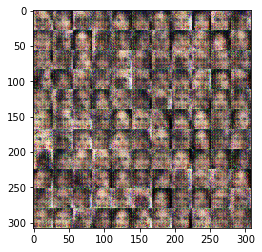

Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 2.9448
Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 1.9617
Epoch 1/1... Discriminator Loss: 0.0797... Generator Loss: 3.3008
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 3.6797
Epoch 1/1... Discriminator Loss: 0.2426... Generator Loss: 2.1995
Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 1.9500
Epoch 1/1... Discriminator Loss: 0.0454... Generator Loss: 6.0023
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 1.6453
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 0.9398


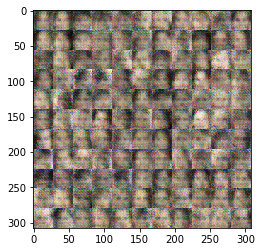

Epoch 1/1... Discriminator Loss: 0.0526... Generator Loss: 6.3290
Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 6.3290
Epoch 1/1... Discriminator Loss: 0.2473... Generator Loss: 1.9000
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 4.1050
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 0.1046... Generator Loss: 4.6132
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 5.6626
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 1.2415


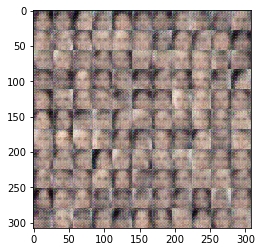

Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 3.0100
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.9473... Generator Loss: 0.2460
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.1402... Generator Loss: 3.9404
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.6568
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 2.3883
Epoch 1/1... Discriminator Loss: 1.9321... Generator Loss: 0.3146


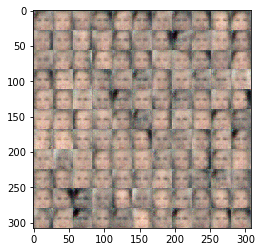

Epoch 1/1... Discriminator Loss: 1.9985... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.7050... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7737


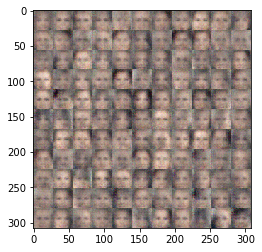

Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.6440


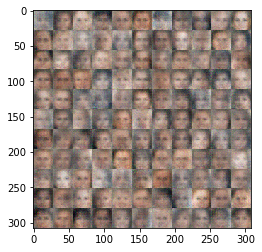

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6924


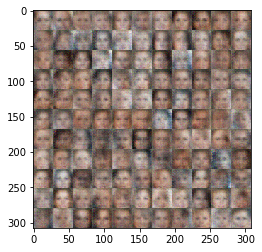

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6904


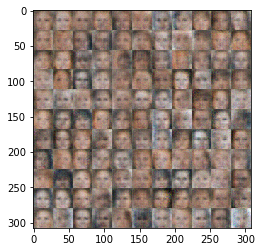

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6985


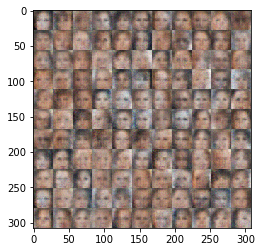

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6941


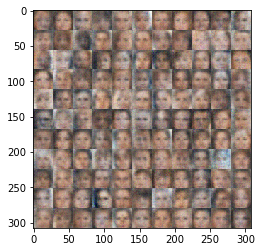

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6848


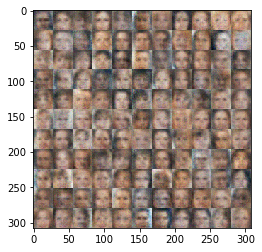

Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6947


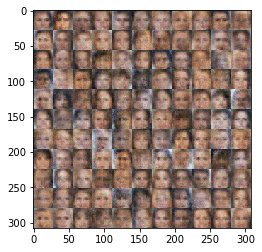

Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7123


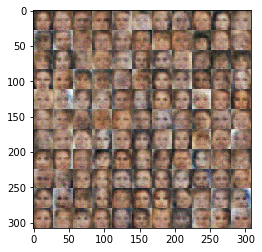

Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8203


In [51]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.